In [1]:
# import sys

# module_path = os.path.abspath(os.path.join('..'))
# if module_path not in sys.path:
#     sys.path.append(module_path)

In [2]:
import datetime
import argparse
import traceback
import os

import torch
import yaml
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
import torchvision
import torch.nn.functional as F
import pandas as pd

from efficientdet.dataset import LabeledDataset, LabeledDataset_coco, Resizer, Normalizer, Augmenter, collater

from backbone import EfficientDetBackbone
from tensorboardX import SummaryWriter
import numpy as np
from tqdm.autonotebook import tqdm
from efficientdet.loss import FocalLoss
from efficientdet.utils import collate_fn_dl
from utils.sync_batchnorm import patch_replication_callback
from utils.utils import replace_w_sync_bn, CustomDataParallel, get_last_weights, init_weights

In [3]:
class Params:
    def __init__(self, project_file):
        self.params = yaml.safe_load(open(project_file).read())

    def __getattr__(self, item):
        return self.params.get(item, None)


def get_args():
    parser = argparse.ArgumentParser('Yet Another EfficientDet Pytorch: SOTA object detection network - Zylo117')
    parser.add_argument('-p', '--project', type=str, default='dl2020', help='project file that contains parameters')
    parser.add_argument('-c', '--compound_coef', type=int, default=0, help='coefficients of efficientdet')
    parser.add_argument('-n', '--num_workers', type=int, default=2, help='num_workers of dataloader')
    parser.add_argument('--batch_size', type=int, default=3, help='The number of images per batch among all devices')
    parser.add_argument('--head_only', type=bool, default=False,
                        help='whether finetunes only the regressor and the classifier, '
                             'useful in early stage convergence or small/easy dataset')
    parser.add_argument('--lr', type=float, default=1e-4)
    parser.add_argument('--optim', type=str, default='adamw', help='select optimizer for training, '
                                                                   'suggest using \'admaw\' until the'
                                                                   ' very final stage then switch to \'sgd\'')
    parser.add_argument('--alpha', type=float, default=0.25)
    parser.add_argument('--gamma', type=float, default=1.5)
    parser.add_argument('--num_epochs', type=int, default=100)
    parser.add_argument('--val_interval', type=int, default=1, help='Number of epoches between valing phases')
    parser.add_argument('--save_interval', type=int, default=500, help='Number of steps between saving')
    parser.add_argument('--es_min_delta', type=float, default=0.0,
                        help='Early stopping\'s parameter: minimum change loss to qualify as an improvement')
    parser.add_argument('--es_patience', type=int, default=0,
                        help='Early stopping\'s parameter: number of epochs with no improvement after which training will be stopped. Set to 0 to disable this technique.')
    parser.add_argument('--data_path', type=str, default='datasets/', help='the root folder of dataset')
    parser.add_argument('--annotation', type=str, default='annotation.csv', help='annotation csv file name')
    parser.add_argument('--log_path', type=str, default='logs/')
    parser.add_argument('--load_weights', type=str, default=None,
                        help='whether to load weights from a checkpoint, set None to initialize, set \'last\' to load last checkpoint')
    parser.add_argument('--saved_path', type=str, default='saved/')
    parser.add_argument('--debug', type=bool, default=False, help='whether visualize the predicted boxes of trainging, '
                                                                  'the output images will be in test/')

    args = parser.parse_args()
    return args


In [4]:
params = Params(f'projects/dl2020.yml')

if params.num_gpus == 0:
    os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
else:
    torch.manual_seed(42)

In [5]:
saved_path = 'saved/' + f'/{params.project_name}/'
log_path = 'logs/' + f'/{params.project_name}/tensorboard/'
os.makedirs(log_path, exist_ok=True)
os.makedirs(saved_path, exist_ok=True)

In [6]:
training_params = {'batch_size': 2,
                   'shuffle': False,
                   'drop_last': True,
                   'collate_fn': collater,
#                    'collate_fn': collate_fn_dl,
                   'num_workers': 0}

val_params = {'batch_size': 2,
              'shuffle': False,
              'drop_last': True,
              'collate_fn': collater,
#               'collate_fn': collate_fn_dl,
              'num_workers': 2}

# Try new data loader

In [7]:
# train_scene_index = np.arange(106, 127)
# val_scene_index = np.arange(128, 134)
# input_sizes = [512, 640, 768, 896, 1024, 1280, 1280, 1536]

# transform_dl = torchvision.transforms.ToTensor()

# transform = transforms.Compose([Normalizer(mean=params.mean, std=params.std),\
#                                 Augmenter(),\
#                                 Resizer(input_sizes[0])])

# training_set = LabeledDataset(image_folder = os.path.join('datasets/', params.project_name),
#                                   annotation_file = os.path.join('datasets/', params.project_name, 'annotation.csv'),
#                                   scene_index = train_scene_index,
#                                   transform = transform_dl,
# #                                   transform = transform,
#                                   extra_info = True
#                                   )

# training_generator = DataLoader(training_set, **training_params)


# val_set = LabeledDataset(image_folder = os.path.join('datasets/', params.project_name),
#                                   annotation_file = os.path.join('datasets/', params.project_name, 'annotation.csv'),
#                                   scene_index = val_scene_index,
#                                   transform = transform_dl,
#                                   extra_info = True
#                                   )

# val_generator = DataLoader(val_set, **val_params)


In [8]:
train_scene_index = np.arange(106, 127)
val_scene_index = np.arange(128, 134)
input_sizes = [512, 640, 768, 896, 1024, 1280, 1280, 1536]

transform = transforms.Compose([Normalizer(mean=params.mean, std=params.std),\
                                Augmenter(),\
                                Resizer(input_sizes[0])])

training_set = LabeledDataset_coco(image_folder = os.path.join('datasets/', params.project_name),
                                  annotation_file = os.path.join('datasets/', params.project_name, 'annotation_newfeat_2.csv'),
                                  scene_index = train_scene_index,
                                  transform = transform,
                                  extra_info = True
                                  )
training_generator = DataLoader(training_set, **training_params)

val_set = LabeledDataset_coco(image_folder = os.path.join('datasets/', params.project_name),
                                  annotation_file = os.path.join('datasets/', params.project_name, 'annotation_newfeat_2.csv'),
                                  scene_index = val_scene_index,
                                  transform = transform,
                                  extra_info = True
                                  )

val_generator = DataLoader(val_set, **val_params)



In [9]:
# progress_bar = tqdm(training_generator)
# for iter, data in enumerate(progress_bar):
#     imgs = data['img']
#     annot = data['annot']
    
#     break

In [10]:
# import matplotlib
# import matplotlib.pyplot as plt
# matplotlib.rcParams['figure.figsize'] = [5, 5]
# matplotlib.rcParams['figure.dpi'] = 200
# # plt.figure(figsize=(3,18))
# plt.imshow(torchvision.utils.make_grid(imgs[0], nrow=3).numpy().transpose(1, 2, 0))
# plt.axis('off');

In [11]:
model = EfficientDetBackbone(num_classes=len(params.obj_list), compound_coef = 0,
                             ratios=eval(params.anchors_ratios), scales=eval(params.anchors_scales))

In [12]:
load_weights = None
if load_weights is not None:
    if opt.load_weights.endswith('.pth'):
        weights_path = opt.load_weights
    else:
        weights_path = get_last_weights(opt.saved_path)
    try:
        last_step = int(os.path.basename(weights_path).split('_')[-1].split('.')[0])
    except:
        last_step = 0

    try:
        ret = model.load_state_dict(torch.load(weights_path), strict=False)
    except RuntimeError as e:
        print(f'[Warning] Ignoring {e}')
        print(
            '[Warning] Don\'t panic if you see this, this might be because you load a pretrained weights with different number of classes. The rest of the weights should be loaded already.')

    print(f'[Info] loaded weights: {os.path.basename(weights_path)}, resuming checkpoint from step: {last_step}')
else:
    last_step = 0
    print('[Info] initializing weights...')
    init_weights(model)
    
    
    
    
    

[Info] initializing weights...


In [13]:
# if opt.head_only:
#     def freeze_backbone(m):
#         classname = m.__class__.__name__
#         for ntl in ['EfficientNet', 'BiFPN']:
#             if ntl in classname:
#                 for param in m.parameters():
#                     param.requires_grad = False

#     model.apply(freeze_backbone)
#     print('[Info] freezed backbone')

In [14]:
if params.num_gpus > 1 and 3 // params.num_gpus < 4:
    model.apply(replace_w_sync_bn)
    use_sync_bn = True
else:
    use_sync_bn = False

In [15]:
writer = SummaryWriter(log_path + f'/{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}/')

In [16]:
class ModelWithLoss(nn.Module):
    def __init__(self, model, debug=False):
        super().__init__()
        self.criterion = FocalLoss()
        self.model = model
        self.debug = debug

    def forward(self, imgs, annotations, obj_list=None):
        _, regression, classification, anchors = self.model(imgs)
        if self.debug:
            cls_loss, reg_loss = self.criterion(classification, regression, anchors, annotations,
                                                imgs=imgs, obj_list=obj_list)
        else:
            cls_loss, reg_loss = self.criterion(classification, regression, anchors, annotations)
        return cls_loss, reg_loss, regression, classification, anchors

model = ModelWithLoss(model, debug= False)

In [17]:
# if params.num_gpus > 0:
#     model = model.cuda()
#     if params.num_gpus > 1:
#         model = CustomDataParallel(model, params.num_gpus)
#         if use_sync_bn:
#             patch_replication_callback(model)

In [18]:
optim = 'adamw'
if optim == 'adamw':
    optimizer = torch.optim.AdamW(model.parameters(), 1e-4)
else:
    optimizer = torch.optim.SGD(model.parameters(), 1e-4, momentum=0.9, nesterov=True)

In [19]:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, verbose=True)

In [20]:
epoch = 0
best_loss = 1e5
best_epoch = 0
step = max(0, last_step)
model.train()

num_iter_per_epoch = len(training_generator)

In [21]:
def save_checkpoint(model, name):
    if isinstance(model, CustomDataParallel):
        torch.save(model.module.model.state_dict(), os.path.join('saved/', name))
    else:
        torch.save(model.model.state_dict(), os.path.join('saved/', name))

In [22]:
for epoch in range(10):
    last_epoch = step // num_iter_per_epoch
    if epoch < last_epoch:
        continue


    epoch_loss = []
    progress_bar = tqdm(training_generator)
    for iter, data in enumerate(progress_bar):
        if iter < step - last_epoch * num_iter_per_epoch:
            progress_bar.update()
            continue
            
        imgs = data['img']
        annot = data['annot']

#         sample_cat, sample, target, road_image, extra = data     
#         sample_cat = torch.stack(sample_cat)

        if params.num_gpus == 1:
            # if only one gpu, just send it to cuda:0
            # elif multiple gpus, send it to multiple gpus in CustomDataParallel, not here
            imgs = imgs.cuda()
            annot = annot.cuda()
            
            
        optimizer.zero_grad()
        
        
        
#         criterion = FocalLoss()
#         _, regression, classification, anchors = model(imgs)
#         cls_loss, reg_loss = criterion(classification, regression, anchors, annot)

        
        cls_loss, reg_loss, regression, classification, anchors = model(imgs, annot, obj_list=params.obj_list)
#         cls_loss, reg_loss = model(imgs, target, obj_list=params.obj_list)


        cls_loss = cls_loss.mean()
        reg_loss = reg_loss.mean()


        print(cls_loss)
        print(reg_loss)

        loss = cls_loss + reg_loss
        if loss == 0 or not torch.isfinite(loss):
            continue
            
            
        loss.backward()
        # torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        optimizer.step()

        epoch_loss.append(float(loss))

        progress_bar.set_description(
            'Step: {}. Epoch: {}/{}. Iteration: {}/{}. Cls loss: {:.5f}. Reg loss: {:.5f}. Total loss: {:.5f}'.format(
                step, epoch, 10, iter + 1, num_iter_per_epoch, cls_loss.item(),
                reg_loss.item(), loss.item()))
        writer.add_scalars('Loss', {'train': loss}, step)
        writer.add_scalars('Regression_loss', {'train': reg_loss}, step)
        writer.add_scalars('Classfication_loss', {'train': cls_loss}, step)

        
        # log learning_rate
        current_lr = optimizer.param_groups[0]['lr']
        writer.add_scalar('learning_rate', current_lr, step)

        step += 1

        if step % 1 == 0 and step > 0:
            save_checkpoint(model, f'efficientdet-d{0}_{epoch}_{step}.pth')
            print('checkpoint...')
            
            
    
        break
    
    break
    scheduler.step(np.mean(epoch_loss))

image_size: (768, 612, 3)
image_size: (768, 612, 3)
tensor(4498.1997, grad_fn=<MeanBackward0>)
tensor(1.4827, grad_fn=<MeanBackward0>)
checkpoint...


In [23]:
# if epoch % opt.val_interval == 0:
#     model.eval()
#     loss_regression_ls = []
#     loss_classification_ls = []
#     for iter, data in enumerate(val_generator):
#         with torch.no_grad():
#             imgs = data['img']
#             annot = data['annot']

#             if params.num_gpus == 1:
#                 imgs = imgs.cuda()
#                 annot = annot.cuda()

#             cls_loss, reg_loss, regression, classification, anchors = model(imgs, annot, obj_list=params.obj_list)
#             cls_loss = cls_loss.mean()
#             reg_loss = reg_loss.mean()

#             loss = cls_loss + reg_loss
#             if loss == 0 or not torch.isfinite(loss):
#                 continue

#             loss_classification_ls.append(cls_loss.item())
#             loss_regression_ls.append(reg_loss.item())

#     cls_loss = np.mean(loss_classification_ls)
#     reg_loss = np.mean(loss_regression_ls)
#     loss = cls_loss + reg_loss

#     print(
#         'Val. Epoch: {}/{}. Classification loss: {:1.5f}. Regression loss: {:1.5f}. Total loss: {:1.5f}'.format(
#             epoch, opt.num_epochs, cls_loss, reg_loss, loss))
#     writer.add_scalars('Total_loss', {'val': loss}, step)
#     writer.add_scalars('Regression_loss', {'val': reg_loss}, step)
#     writer.add_scalars('Classfication_loss', {'val': cls_loss}, step)

#     if loss + opt.es_min_delta < best_loss:
#         best_loss = loss
#         best_epoch = epoch

#         save_checkpoint(model, f'efficientdet-d{opt.compound_coef}_{epoch}_{step}.pth')

#     model.train()

In [24]:
regression.shape

torch.Size([2, 54560, 4])

In [25]:
classification.shape

torch.Size([2, 54560, 9])

In [26]:
anchors.shape

torch.Size([1, 54560, 4])

In [27]:
anchors
# y1, y2, x1, x2

tensor([[[  0.0000,   0.0000,   8.0000,   8.0000],
         [  1.2000,  -1.6000,   6.8000,   9.6000],
         [ -1.6000,   1.2000,   9.6000,   6.8000],
         ...,
         [403.2000, 425.6000, 492.8000, 470.4000],
         [427.8400, 397.6000, 468.1600, 498.4000],
         [397.6000, 427.8400, 498.4000, 468.1600]]])

In [28]:
annots = pd.read_csv('datasets/dl2020/annotation_newfeat_2.csv')

In [29]:
true_boxes = annots.loc[:, ['scaled_x', 'scaled_y', 'scaled_box_width', 'scaled_box_height']]

In [30]:
true_boxes = true_boxes.rename(columns = {'scaled_x':'x1', 'scaled_y':'y1'})

In [31]:
true_boxes['x2'] = true_boxes['x1'] + true_boxes['scaled_box_width']
true_boxes['y2'] = true_boxes['y1'] + true_boxes['scaled_box_height']

In [32]:
true_boxes.head()

,x1,y1,scaled_box_width,scaled_box_height,x2,y2
0,196.707221,180.733722,35.114737,18.424762,231.821958,199.158484
1,260.842884,86.143868,34.572071,23.275205,295.414955,109.419073
2,583.571009,567.618014,7.775271,10.620019,591.346280,578.238033
3,285.006699,305.930750,36.208618,18.436969,321.215317,324.367718
4,568.659812,333.241961,36.208618,18.436969,604.868430,351.678930


In [33]:
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.rcParams['figure.figsize'] = [5, 5]
# matplotlib.rcParams['figure.dpi'] = 200

(array([2.3220e+03, 3.1620e+03, 1.4700e+04, 2.4554e+04, 3.7430e+03,
        1.0900e+03, 7.1600e+02, 3.3720e+03, 4.2030e+03, 1.2510e+03,
        3.2600e+02, 5.8000e+01, 1.0000e+01, 4.0000e+00, 3.1000e+01,
        2.6000e+01, 4.0000e+00, 7.0000e+00, 1.5000e+01, 1.2000e+01,
        5.0000e+00, 2.5000e+01, 2.9000e+01, 0.0000e+00, 3.6000e+01,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.4000e+01]),
 array([  2.40898868,   7.79459909,  13.1802095 ,  18.56581991,
         23.95143033,  29.33704074,  34.72265115,  40.10826157,
         45.49387198,  50.87948239,  56.26509281,  61.65070322,
         67.03631363,  72.42192404,  77.80753446,  83.19314487,
         88.57875528,  93.9643657 ,  99.34997611, 104.73558652,
        110.12119694, 115.50680735, 120.89241776, 126.27802817,
        131.66363859, 137.049249  , 142.43485941, 147.82046983,
        153.20608024, 158.59169065, 163.97730107]),
 <a list of 30 Patch objects>)

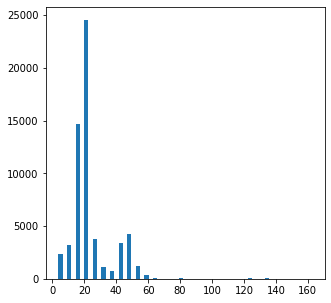

In [54]:
plt.figure(figsize = (5,5))
plt.hist(true_boxes.scaled_box_height, bins = 30, rwidth = 0.5)

(array([1.2288e+04, 1.8432e+04, 5.1200e+03, 1.2800e+03, 6.4000e+03,
        5.1200e+03, 1.2800e+03, 0.0000e+00, 3.2000e+02, 1.6000e+03,
        0.0000e+00, 1.2800e+03, 0.0000e+00, 0.0000e+00, 3.2000e+02,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 8.0000e+01, 0.0000e+00,
        0.0000e+00, 4.0000e+02, 0.0000e+00, 0.0000e+00, 3.2000e+02,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        8.0000e+01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.6000e+01,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 9.6000e+01, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 8.0000e+01,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.6000e+01, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.00

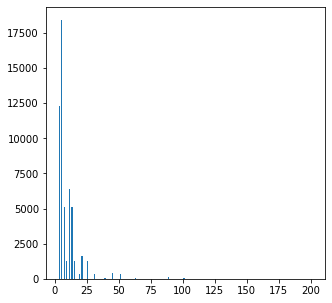

In [46]:
plt.figure(figsize = (5,5))
plt.hist(anchors[0, :, 2] - anchors[0, :, 0], bins = 100, rwidth = 0.5)
plt.xlim(0, 160)

In [49]:
sum(true_boxes.scaled_box_width < 2.5)

12

In [52]:
sum(anchors[0, :, 2] - anchors[0, :, 0] > 100)

tensor(128)

In [53]:
sum(true_boxes.scaled_box_height > 100)

135

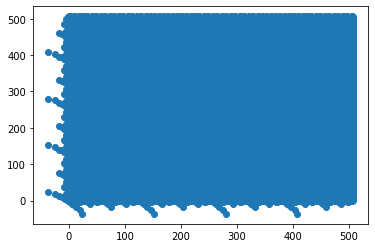

In [55]:
plt.scatter(anchors[0, :, 1], anchors[0, :, 0])

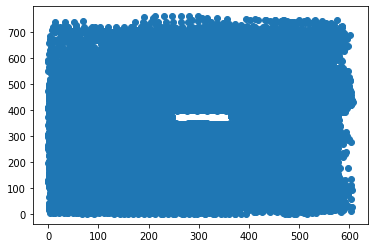

In [56]:
plt.scatter(true_boxes.x1, true_boxes.y1)